In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import albumentations as A

In [ ]:
# Define function to apply weather effects
def apply_weather_effect(image, effect_type="rain"):
    if effect_type == "rain":
        transform = A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=3, p=1)
    elif effect_type == "snow":
        transform = A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)
    return transform(image=image)['image']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
image_data_dir = "/content/drive/My Drive/CNN/Dataset/train_images"
image_filenames = os.listdir(image_data_dir)
labels_data = pd.read_csv("/content/drive/My Drive/CNN/Dataset/labels.csv")

# Preprocess and separate original and augmented data
original_images = []
augmented_images = []
original_labels = []
augmented_labels = []

for filename in image_filenames:
    image_path = os.path.join(image_data_dir, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image is not None else None
    if image is not None and filename in labels_data['image_filename'].values:
        label = labels_data[labels_data['image_filename'] == filename]['label'].iloc[0]
        original_images.append(image)
        original_labels.append(label)

        # Randomly decide to augment with weather effects
        if np.random.rand() < 0.5:  # 50% chance to augment
            effect_type = np.random.choice(["rain", "snow"])
            aug_image = apply_weather_effect(image, effect_type=effect_type)
            augmented_images.append(aug_image)
            augmented_labels.append(label)

In [ ]:
# Convert lists to arrays
X_original = np.array(original_images)
y_original = to_categorical(np.array(original_labels))
X_augmented = np.array(augmented_images)
y_augmented = to_categorical(np.array(augmented_labels))

# Combine original and augmented for validation and testing
X_combined = np.concatenate((X_original, X_augmented))
y_combined = np.concatenate((y_original, y_augmented))

# Split into training, validation, and test sets
X_train_orig, X_temp, y_train_orig, y_temp = train_test_split(X_original, y_original, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, test_size=0.5, random_state=42)  # Split combined for validation and testing

X_train_aug, _, y_train_aug, _ = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)  # Training set for augmented model

In [ ]:
from tensorflow.keras.applications import InceptionV3

def create_model(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [ ]:
# Create and train baseline model
baseline_model = create_model(X_train_orig.shape[1:], y_train_orig.shape[1])
baseline_history = baseline_model.fit(X_train_orig, y_train_orig, epochs=40, validation_data=(X_val, y_val))


87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/40
21/21 [==============================] - 18s 374ms/step - loss: 436.2143 - accuracy: 0.5491 - val_loss: 0.6930 - val_accuracy: 0.4766
Epoch 2/40
21/21 [==============================] - 2s 119ms/step - loss: 0.6935 - accuracy: 0.4633 - val_loss: 0.6928 - val_accuracy: 0.4766
Epoch 3/40
21/21 [==============================] - 2s 121ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6925 - val_accuracy: 0.5263
Epoch 4/40
21/21 [==============================] - 2s 120ms/step - loss: 0.6928 - accuracy: 0.5367 - val_loss: 0.6921 - val_accuracy: 0.5263
Epoch 5/40
21/21 [==============================] - 2s 119ms/step - loss: 0.6923 - accuracy: 0.5367 - val_loss: 0.6919 - val_accuracy: 0.5263
Epoch 6/40
21/21 [==============================] - 2s 118ms/step - loss: 0.6921 - accuracy: 0.5367 - val_loss: 0.6919 - val_accuracy: 0.5263
Epoch 7/40
21/21 [==============================] - 2s 118ms/step - loss: 0.6918

In [ ]:
# Create and train augmented model
augmented_model = create_model(X_train_aug.shape[1:], y_train_aug.shape[1])
augmented_history = augmented_model.fit(X_train_aug, y_train_aug, epochs=40, validation_data=(X_val, y_val))


Epoch 1/40
10/10 [==============================] - 12s 808ms/step - loss: 876.9949 - accuracy: 0.5601 - val_loss: 115.8352 - val_accuracy: 0.5906
Epoch 2/40
10/10 [==============================] - 2s 194ms/step - loss: 79.1966 - accuracy: 0.5949 - val_loss: 52.8570 - val_accuracy: 0.6930
Epoch 3/40
10/10 [==============================] - 2s 197ms/step - loss: 48.4073 - accuracy: 0.6899 - val_loss: 39.0669 - val_accuracy: 0.6564
Epoch 4/40
10/10 [==============================] - 2s 196ms/step - loss: 16.7159 - accuracy: 0.7627 - val_loss: 31.6336 - val_accuracy: 0.6184
Epoch 5/40
10/10 [==============================] - 2s 195ms/step - loss: 15.2401 - accuracy: 0.7690 - val_loss: 8.0876 - val_accuracy: 0.8582
Epoch 6/40
10/10 [==============================] - 2s 195ms/step - loss: 8.4655 - accuracy: 0.8766 - val_loss: 10.2051 - val_accuracy: 0.8392
Epoch 7/40
10/10 [==============================] - 2s 195ms/step - loss: 4.8112 - accuracy: 0.9051 - val_loss: 13.2351 - val_accuracy:

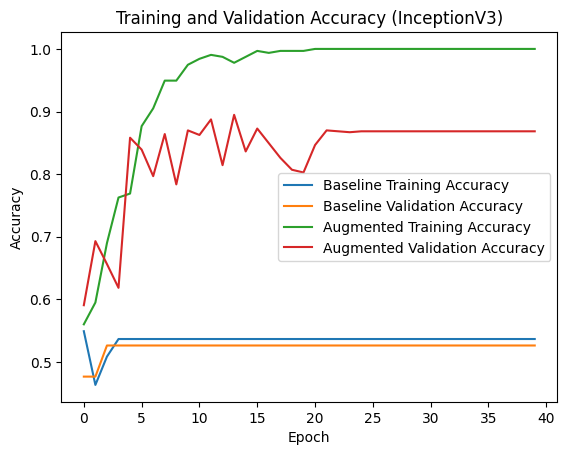

In [ ]:
import matplotlib.pyplot as plt
plt.plot(baseline_history.history['accuracy'], label='Baseline Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Validation Accuracy')
plt.plot(augmented_history.history['accuracy'], label='Augmented Training Accuracy')
plt.plot(augmented_history.history['val_accuracy'], label='Augmented Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (InceptionV3)')
plt.legend()
plt.show()

In [ ]:
# Evaluate both models on the test set
baseline_score = baseline_model.evaluate(X_test, y_test, verbose=0)
augmented_score = augmented_model.evaluate(X_test, y_test, verbose=0)
print("Baseline Model - Test loss:", baseline_score[0], "Test accuracy:", baseline_score[1])
print("Augmented Model - Test loss:", augmented_score[0], "Test accuracy:", augmented_score[1])

Baseline Model - Test loss: 0.6854309439659119 Test accuracy: 0.5716374516487122
Augmented Model - Test loss: 5.966674327850342 Test accuracy: 0.8654970526695251
